# 2D iTEBD
In this tutorail, we want to generalize the iTEBD algorithm to two dimensions. 

In [13]:
import pyUni10 as uni10
import numpy as np
import copy

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt

### Define the Hamiltonian

\begin{equation}
H=-\sum_{\langle ij\rangle} \sigma_i^z\sigma_j^z +h \sum_i \sigma_i^x
\end{equation}

In [14]:
def matSp():
  spin = 0.5
  dim = int(spin * 2 + 1)
  return uni10.Matrix(dim, dim, [0, 1, 0, 0]);

def matSm():
  spin = 0.5
  dim = int(spin * 2 + 1)
  return uni10.Matrix(dim, dim, [0, 0, 1, 0]);

def matSz():
  spin = 0.5
  dim = int(spin * 2 + 1)
  return uni10.Matrix(dim, dim, [0.5, 0, 0, -0.5]);

def transverseIsing(h):
    spin = 0.5
    sx = 0.5*(matSp()+matSm())
    sz = matSz()
    iden = uni10.Matrix(2,2, [1, 0, 0, 1])
    ham =uni10.otimes(2*sz,2*sz)*(-1) +0.25*float(h)*(uni10.otimes(iden,2*sx)+uni10.otimes(2*sx,iden))
    dim = int(spin * 2 + 1)
    bdi = uni10.Bond(uni10.BD_IN, dim);
    bdo = uni10.Bond(uni10.BD_OUT, dim);
    H =  uni10.UniTensor([bdi, bdi, bdo, bdo], "TFIM");
    H.putBlock(ham)
    return H



###Helper functions

1. `bondcat(T,L,bidx)`: merge  UniTensors *T* and  *L* at bond *idx*
2. `bondrm(T,L,bidx)`: apply  $L^{-1}$ to bond *idx* of *T* 

In [15]:
def bondcat(T, L, bidx):
    labels = T.label();
    per_labels = list(T.label())
    per_labels.insert(0, per_labels.pop(bidx))
    inBondNum = T.inBondNum();
    T.permute(per_labels, 1)
    T.putBlock(L * T.getBlock())
    T.permute(labels, inBondNum);
    return T

def bondrm(T, L, bidx):
    invL = uni10.Matrix(L.row(), L.col(), True)
    for i in xrange(L.elemNum()):
        invL[i] = 0 if L[i] == 0 else 1.0 / L[i]
    return bondcat(T, invL, bidx)


###Simultation parameters

* chi : bond dimension $\chi$
* delta: time step $\delta$ 
* N : number of iterations
* z : coordination number
* H : Hamiltonian

In [16]:
chi = 3
delta = 0.001
N = 5000
H = transverseIsing(0.8)
z=4

### Setup bonds
Define a bond of dimension $\chi$

Define a bond list of [$\chi,\chi,\ldots, d$] with $z$ virtual bonds, and one physical with dimension $d$

In [17]:

bdi_chi = uni10.Bond(uni10.BD_IN, chi);
bond_list=[]
for i in range(z):
    bond_list.append(bdi_chi)
bond_list.append(H.bond(2)) 


`H.bond(2)` is the third bond from the Hamiltonian. This can make sure that we get the same physical dimensions for the tensor and the Hamiltonian

### Set up $\Gamma$ tensors and $\lambda$ matrices 

Intialize the $\Gamma$ and $\lambda$ tensors. Notice that $\lambda$s are diagonal matrices.

In [18]:
Gs = []
Gs.append(uni10.UniTensor(bond_list, "Ga"))
Gs.append(uni10.UniTensor(bond_list, "Gb"))
Gs[0].randomize(), Gs[1].randomize()


I_chi = uni10.Matrix(chi, chi, True)
I_chi.randomize()

Ls = []
for i in range(z):
    Ls.append(uni10.Matrix(chi, chi, True))  # Diagonal matrix
    Ls[i]=copy.copy(I_chi)

### Define the evolution operator 
\begin{equation}
U=e^{-\delta H}
\end{equation}

In [19]:
U = uni10.UniTensor(H.bond(), "U");
U.putBlock(uni10.takeExp(-delta, H.getBlock()))

###  Main update loop

This is the main part that performs the updates. 

Please see the tutorial for labels associated with each tensors.
http://uni10-tutorials.readthedocs.org/en/latest/lecture3.html#d-itebd

In [20]:
Elist=[]
for step in range(N):
    E=0.0

    # Loop through bonds
    for bond in range(z):
        Gs_A_l=copy.copy(Gs[0]) # make a copy of Gs[0]
        Gs_A_l.setName("Gs_Al")

        # merge Ls other than Ls[bond] with Gs_A_l
        for b in range(1,z):
            Gs_A_l=bondcat(Gs_A_l, Ls[(bond+b) % z], ((bond+b) % z))
        # merge Ls[bond] with Gs_A_l
        Gs_A_l=bondcat(Gs_A_l, Ls[bond], bond) 

        # move the label corrsponding to bond to the first
        per_labels = list(Gs_A_l.label())
        per_labels.insert(0, per_labels.pop(bond))
        inBondNum = Gs_A_l.inBondNum();
        Gs_A_l.permute(per_labels, inBondNum)
        
        # Obtain a list of merged bonds. 
        # Start from bond+1 to bond+z-1 mod z
        
        A_merged_bonds=[ (bond+i)%z for i in range(1,z)]

        # For z=2, we don't have to combine the bonds
        if len(A_merged_bonds) > 1 :
            Gs_A_l.combineBond(A_merged_bonds)


        Gs_B_l=copy.copy(Gs[1])
        Gs_B_l.setName("Gs_Bl")


        for b in range(1,z):
            Gs_B_l=bondcat(Gs_B_l, Ls[(bond+b) % z], (bond+b) % z)


        per_labels = list(Gs_B_l.label())
        per_labels.insert(0, per_labels.pop(bond))
        inBondNum = Gs_B_l.inBondNum();
        Gs_B_l.permute(per_labels, inBondNum)

        B_merged_bonds=[ (bond+i)%z for i in range(1,z)]

        if len(B_merged_bonds) > 1:
            Gs_B_l.combineBond(B_merged_bonds)

        Gs_A_l.setLabel([3, -1, 1]);
        Gs_B_l.setLabel([3, -3 , 2]);
        U.setLabel([1, 2, -2, -4]);

        theta = uni10.contract(Gs_A_l, Gs_B_l, True) # Gs[0], Gs[1] is permuted atfer the execution
        Ntheta=theta # to be used to calculate the norm
        theta *= U;
        theta.permute([-1, -2, -3, -4], 2);



        # SVD
        svd = theta.getBlock().svd()

        # Truncation
        sv = svd[1]
        norm = sv.resize(chi, chi).norm()
        sv = sv * (1.0 / norm);
        Ls[bond] = sv

        # put the SVD results back into Gs_A_l and Gs_B_l

        Gs_A_l.putBlock(svd[0].resize(svd[0].row(),chi));
        Gs_B_l.putBlock(svd[2].resize(chi,svd[2].col()));


        # permute the bonds back to the original order
        
        Gs_A_l.permute([3,-1,1],2)
        Gs_B_l.permute([3,-3,2],2)

        labels=list(Gs[0].label())

        # per_labels is used to permute Gs[0] to the same form as Gs_A_l
        per_labels=[bond]+A_merged_bonds+[z]

        # put  Gs_A_l into Gs[0]
        Gs[0].permute(per_labels,z)
        Gs[0].putBlock(Gs_A_l.getBlock())

        # permute the bonds back
        Gs[0].permute(labels,z)

        labels=list(Gs[1].label())
        per_labels=[bond]+B_merged_bonds+[z]


        Gs[1].permute(per_labels,z)
        Gs[1].putBlock(Gs_B_l.getBlock())
        Gs[1].permute(labels,z)
        
        # remove Ls's from Gs[0] 
        for j in A_merged_bonds:
            Gs[0] = bondrm(Gs[0], Ls[j], j);
        for j in B_merged_bonds:
            Gs[1] = bondrm(Gs[1], Ls[j], j);

        Ebond = (theta*theta)[0]
        Nbond = (Ntheta * Ntheta)[0]
        E_b=-np.log(Ebond)/delta/2/z
        E+=E_b/Nbond
    if step % 500 == 0:
        print 'E=',E
    Elist.append(E)

E= -153.749618216
E= -1.15727599234
E= -1.15952203039
E= -1.1595258348
E= -1.15952584175
E= -1.15952584176
E= -1.15952584176
E= -1.15952584176
E= -1.15952584176
E= -1.15952584176


(-2, 1)

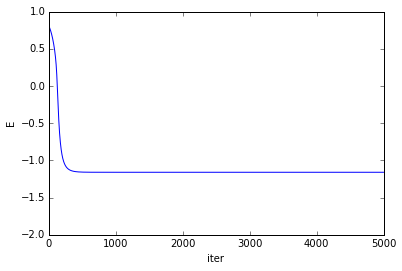

In [21]:
plt.plot(Elist)
plt.xlabel('iter')
plt.ylabel('E')
plt.ylim([-2,1])

In [22]:
LU=0.5*(Ls[0]+Ls[2])
LR=0.5*(Ls[1]+Ls[3])
GaL=copy.copy(Gs[0])
GaL=bondcat(GaL,LU,0)
GaL=bondcat(GaL,LR,1)
# permute the physical bond to the first index 
# for the next part of the tutorial
GaL.permute([4,0,1,2,3],1) 
GaL.save("GaL.ten")
GbL=copy.copy(Gs[1])
GbL=bondcat(GbL,LU,0)
GbL=bondcat(GbL,LR,1)
# permute the physical bond to the first index 
# for the next part of the tutorial
GbL.permute([4,0,1,2,3],1)
GbL.save("GbL.ten")